# Real Estate Price Prediction Engine — Technical Challenge

## Executive Summary
- Goal: Predict transaction price (TRANS_VALUE) from transaction + property attributes.
- Validation: Time-based split to simulate real deployment (train on past, test on future).
- Final system: Segmented modeling (MAIN vs LAND) with CatBoost; MAIN uses leakage-safe market priors.
- Headline performance (TEST):
  - MAIN (Unit+Building): R²(log)=..., MAE=..., MAPE=...
  - LAND: R²(log)=..., MAE=..., MAPE=...
- Explainability: Feature importance + SHAP; uncertainty via calibrated intervals.

## Problem Definition

The objective of this project is to predict real estate transaction prices
(`TRANS_VALUE`) using historical transaction and property-level data.

This is a supervised regression problem with a highly skewed target variable.
The primary goal is to build a model that generalizes well to future, unseen
transactions under realistic deployment conditions, rather than maximizing
performance on historical data alone.


In [13]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:

import lightgbm as lgb
from xgboost import XGBRegressor

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor

from sklearn.linear_model import Ridge
import matplotlib.dates as mdates
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("Setup complete. pandas:", pd.__version__)


Setup complete. pandas: 3.0.0


### 02 — Load Dataset (Repo-Aware Path Resolution)

This cell resolves file-loading issues by explicitly setting the **repository root**:

- Detects that the notebook is running inside the `notebooks/` directory
- Moves one level up to the project root using `Path.cwd().parent`
- Recursively searches for `transactions-2025-03-21.csv` under the repo
- Loads the dataset only after confirming its location

Outcome: the dataset is now loaded in a way that is **robust, OS-safe**.
##  Initial Inspection

 a basic inspection to understand
its structure, size, and temporal coverage.

This step helps verify data integrity, confirm the presence of a time dimension,
and identify any immediate data quality issues before deeper analysis.

In [17]:


from pathlib import Path


repo_root = Path.cwd().parent

print("Repo root:", repo_root)

# Search for the CSV under repo root
matches = list(repo_root.rglob("transactions-2025-03-21.csv"))

print("Matches found:", len(matches))
for m in matches:
    print(" -", m)

if not matches:
    raise FileNotFoundError("transactions-2025-03-21.csv not found under repo root")

DATA_PATH = matches[0]
df = pd.read_csv(DATA_PATH)
df["INSTANCE_DATE"] = pd.to_datetime(df["INSTANCE_DATE"], errors="coerce")

display(df.head(3))

Repo root: d:\real_estate_price_engine\real_estate_price_engine
Matches found: 1
 - d:\real_estate_price_engine\real_estate_price_engine\dataset\raw\transactions-2025-03-21.csv


,TRANSACTION_NUMBER,INSTANCE_DATE,GROUP_EN,PROCEDURE_EN,IS_OFFPLAN_EN,IS_FREE_HOLD_EN,USAGE_EN,AREA_EN,PROP_TYPE_EN,PROP_SB_TYPE_EN,TRANS_VALUE,PROCEDURE_AREA,ACTUAL_AREA,ROOMS_EN,PARKING,NEAREST_METRO_EN,NEAREST_MALL_EN,NEAREST_LANDMARK_EN,TOTAL_BUYER,TOTAL_SELLER,MASTER_PROJECT_EN,PROJECT_EN
0,101-1-2025,2025-02-06 09:46:41,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Unit,Hotel Apartment,1600000.0,160.62,160.62,2 B/R,1,Dubai Internet City,Marina Mall,Sports City Swimming Academy,0,0,NaN,NORTH FORTY THREE SERVICED RESIDENCES
1,101-1-2025,2025-02-06 09:46:41,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Unit,Hotel Apartment,1600000.0,172.26,172.26,3 B/R,1,Dubai Internet City,Marina Mall,Sports City Swimming Academy,0,0,NaN,NORTH FORTY THREE SERVICED RESIDENCES
2,101-1-2025,2025-02-06 09:46:41,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,JUMEIRAH VILLAGE CIRCLE,Unit,Hotel Apartment,1600000.0,140.05,140.05,3 B/R,1,Dubai Internet City,Marina Mall,Sports City Swimming Academy,0,0,NaN,NORTH FORTY THREE SERVICED RESIDENCES


### Dataset overview

#### Size of the dataset

In [18]:

rows, cols = df.shape
print(f"Dataset size: {rows:,} rows × {cols} columns")

Dataset size: 53,481 rows × 22 columns


#### Date Range

In [19]:
start_date = df["INSTANCE_DATE"].min()
end_date = df["INSTANCE_DATE"].max()
print(f"Date range: {start_date.date()} → {end_date.date()}")


Date range: 2025-01-01 → 2025-03-21


#### Transactions Distribution,per month,per week

In [20]:
print("\nTransactions per year:")
print(df["INSTANCE_DATE"].dt.year.value_counts().sort_index())


Transactions per year:
INSTANCE_DATE
2025    53481
Name: count, dtype: int64


In [21]:
print("\nTransactions per month:")
per_month = (df["INSTANCE_DATE"].dt.to_period("M").value_counts().sort_index())

print(per_month)



Transactions per month:
INSTANCE_DATE
2025-01    18987
2025-02    20317
2025-03    14177
Freq: M, Name: count, dtype: int64


January 2025: A total of 18,987 transactions were recorded between January 1 and January 31, 2025, representing a complete calendar month.

February 2025: A total of 20,317 transactions were recorded between February 1 and February 28, 2025, representing the highest monthly activity in the observed period.

March 2025: A total of 14,177 transactions were recorded between March 1 and March 21, 2025. This count reflects a partial month, as the dataset does not include transactions beyond March 21.

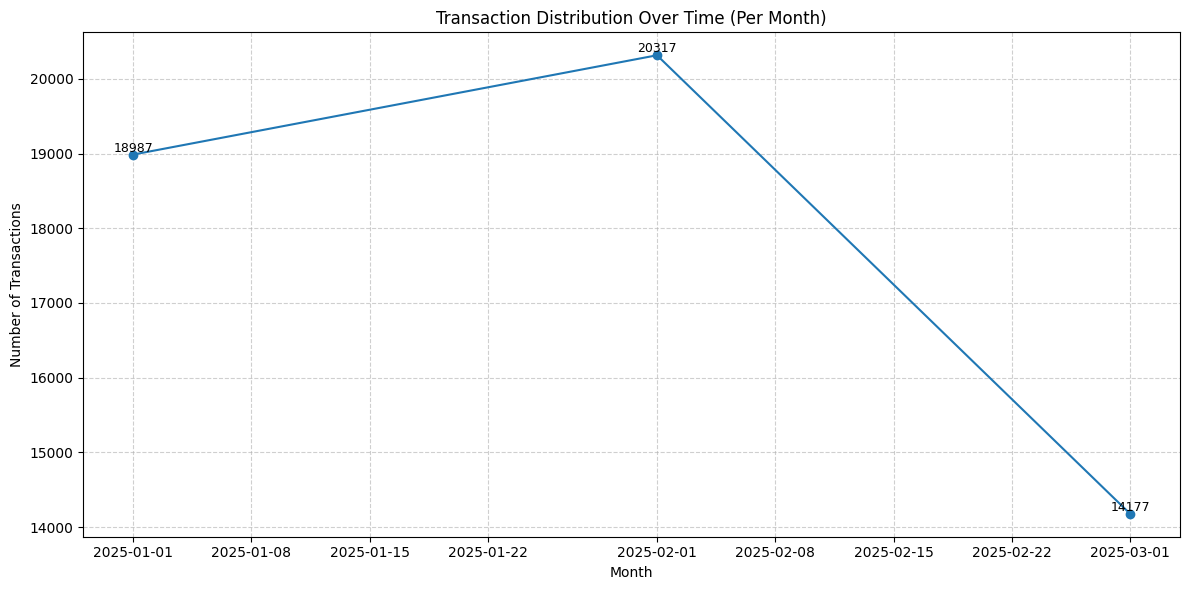

In [22]:
per_month.index = per_month.index.to_timestamp()

plt.figure(figsize=(12, 6))

plt.plot(per_month.index,per_month.values,marker="o",linestyle="-")

plt.title("Transaction Distribution Over Time (Per Month)")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")


plt.grid(True, linestyle="--", alpha=0.6)

for x, y in zip(per_month.index, per_month.values):
    plt.text(
        x,
        y,
        f"{y}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [23]:
print("\nTransactions per week:")
per_week = (df["INSTANCE_DATE"].dt.to_period("W").value_counts().sort_index())

print(per_week)



Transactions per week:
INSTANCE_DATE
2024-12-30/2025-01-05    1216
2025-01-06/2025-01-12    4420
2025-01-13/2025-01-19    4382
2025-01-20/2025-01-26    4648
2025-01-27/2025-02-02    4689
2025-02-03/2025-02-09    4861
2025-02-10/2025-02-16    5014
2025-02-17/2025-02-23    4455
2025-02-24/2025-03-02    5891
2025-03-03/2025-03-09    4964
2025-03-10/2025-03-16    4442
2025-03-17/2025-03-23    4499
Freq: W-SUN, Name: count, dtype: int64


Weekly aggregation reveals stable transaction volumes:

Full weeks typically range between 4,300 and 5,000 transactions

The first and last weeks show lower counts due to partial-week coverage

No abrupt spikes or drops are observed

This pattern indicates consistent reporting and reliable data ingestion.

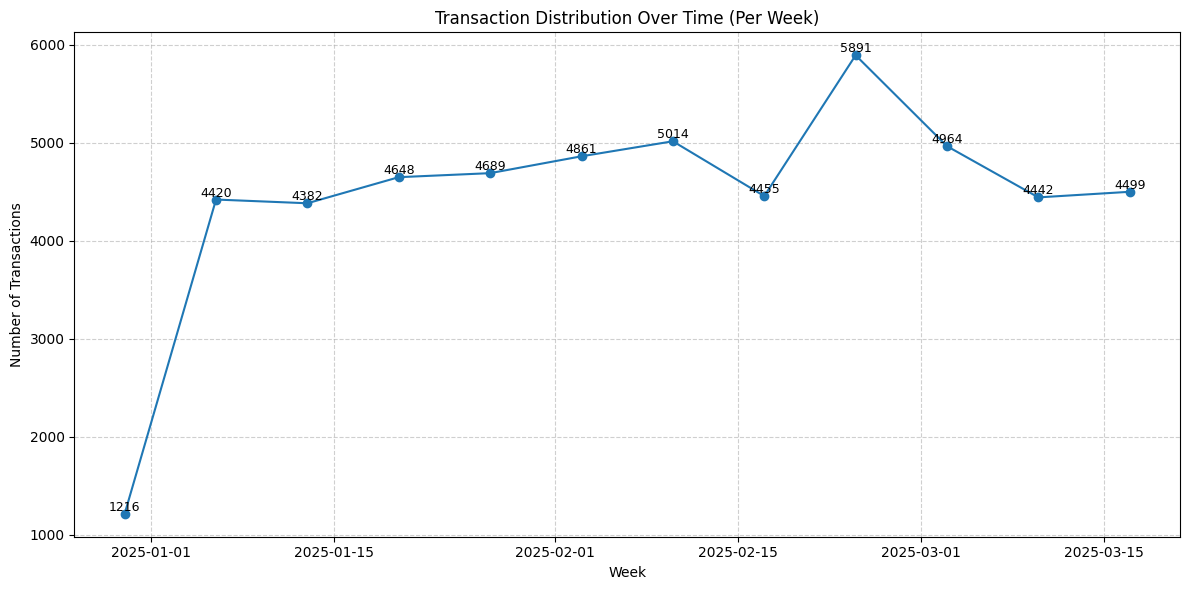

In [24]:
per_week.index = per_week.index.to_timestamp()

plt.figure(figsize=(12, 6))

plt.plot(
    per_week.index,
    per_week.values,
    marker="o",
    linestyle="-"
)

# Title and labels
plt.title("Transaction Distribution Over Time (Per Week)")
plt.xlabel("Week")
plt.ylabel("Number of Transactions")

# Grid for readability
plt.grid(True, linestyle="--", alpha=0.6)

# Annotate each point with count
for x, y in zip(per_week.index, per_week.values):
    plt.text(
        x, y,
        f"{y}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [25]:
print("\nTransaction Value Distribution (TRANS_VALUE)")
print(df["TRANS_VALUE"].describe())


Transaction Value Distribution (TRANS_VALUE)
count    5.348100e+04
mean     3.307043e+06
std      1.736951e+07
min      1.077000e+01
25%      9.277778e+05
50%      1.589300e+06
75%      2.850000e+06
max      1.578530e+09
Name: TRANS_VALUE, dtype: float64


##### Transaction Value Distribution

The transaction value (TRANS_VALUE) shows a highly skewed distribution:

Median: 1.59 million

Mean: 3.31 million

95th percentile: 8.0 million

99th percentile: 28.0 million

Maximum: 1.58 billion

The large gap between median and maximum values confirms the presence of extreme outliers, typical of real estate datasets. This motivates the use of log-scale transformations and robust loss functions during modeling.

####  Dataset Summary and Info

In [26]:
print(df.describe().T)

                  count                        mean                  min                  25%                  50%                  75%  \
INSTANCE_DATE     53481  2025-02-12 03:17:58.784147  2025-01-01 21:47:23  2025-01-23 12:14:21  2025-02-12 11:14:49  2025-03-03 12:40:11   
TRANS_VALUE     53481.0              3307042.817965                10.77            927777.78            1589300.0            2850000.0   
PROCEDURE_AREA  53481.0                  322.817879                 0.83                67.77               101.94               171.68   
ACTUAL_AREA     53481.0                  327.328607                 7.35                68.23               103.26               172.25   
TOTAL_BUYER     53481.0                    0.917092                  0.0                  1.0                  1.0                  1.0   
TOTAL_SELLER    53481.0                    0.866027                  0.0                  1.0                  1.0                  1.0   

                          

In [27]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 53481 entries, 0 to 53480
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TRANSACTION_NUMBER   53481 non-null  str           
 1   INSTANCE_DATE        53481 non-null  datetime64[us]
 2   GROUP_EN             53481 non-null  str           
 3   PROCEDURE_EN         53481 non-null  str           
 4   IS_OFFPLAN_EN        53481 non-null  str           
 5   IS_FREE_HOLD_EN      53481 non-null  str           
 6   USAGE_EN             53481 non-null  str           
 7   AREA_EN              53481 non-null  str           
 8   PROP_TYPE_EN         53481 non-null  str           
 9   PROP_SB_TYPE_EN      51109 non-null  str           
 10  TRANS_VALUE          53481 non-null  float64       
 11  PROCEDURE_AREA       53481 non-null  float64       
 12  ACTUAL_AREA          53481 non-null  float64       
 13  ROOMS_EN             43458 non-null  str  

#### Dataset Overview – Key Observations

* The dataset contains a sufficiently large number of transactions (53,481 records), making it suitable for both exploratory analysis and supervised learning.

* All records fall within a single calendar year (2025), which ensures temporal consistency and avoids cross-year seasonality issues.

* Transaction counts remain stable across full months and weeks, with lower counts only appearing in partial periods.

* Core numerical features (TRANS_VALUE, ACTUAL_AREA) are complete and reliable, while missing values are concentrated in secondary descriptive fields.

* The transaction value (TRANS_VALUE) shows a highly skewed distribution
* The large gap between median and maximum values confirms the presence of extreme outliers, typical of real estate datasets. This motivates the use of log-scale transformations and robust loss functions during modeling.

* The dataset reflects realistic real-estate market behavior and shows no signs of data ingestion gaps or temporal anomalies.* 

## Data Quality Analysis and Analyzing Missing Values

Before modeling, we analyze missing values and categorical cardinality.

This is especially important because the dataset contains high-cardinality
categorical features (e.g., project and area names), which strongly influence
model choice and feature encoding strategy.


In [28]:
missing = (df.isna().mean()*100).sort_values(ascending=False)
display(missing.to_frame("missing_%").head(20))




,missing_%
MASTER_PROJECT_EN,99.814888
NEAREST_MALL_EN,46.904508
NEAREST_METRO_EN,46.119183
NEAREST_LANDMARK_EN,34.690825
PARKING,29.442232
ROOMS_EN,18.741235
PROJECT_EN,14.874441
PROP_SB_TYPE_EN,4.435220
IS_FREE_HOLD_EN,0.000000
IS_OFFPLAN_EN,0.000000


In [15]:
df.isna().sum().sort_values(ascending=False)

MASTER_PROJECT_EN      53382
NEAREST_MALL_EN        25085
NEAREST_METRO_EN       24665
NEAREST_LANDMARK_EN    18553
PARKING                15746
ROOMS_EN               10023
PROJECT_EN              7955
PROP_SB_TYPE_EN         2372
IS_FREE_HOLD_EN            0
IS_OFFPLAN_EN              0
INSTANCE_DATE              0
TRANSACTION_NUMBER         0
PROCEDURE_EN               0
GROUP_EN                   0
ACTUAL_AREA                0
PROCEDURE_AREA             0
TRANS_VALUE                0
PROP_TYPE_EN               0
USAGE_EN                   0
AREA_EN                    0
TOTAL_SELLER               0
TOTAL_BUYER                0
dtype: int64

In [29]:
cat_cols = df.select_dtypes(include=["object"]).columns
card = df[cat_cols].nunique().sort_values(ascending=False)
display(card.to_frame("n_unique").head(20))

C:\Users\Ganesh L\AppData\Local\Temp\ipykernel_35668\2282902804.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include=["object"]).columns


,n_unique
TRANSACTION_NUMBER,51561
PARKING,7825
PROJECT_EN,2115
AREA_EN,247
NEAREST_METRO_EN,54
PROP_SB_TYPE_EN,35
PROCEDURE_EN,29
NEAREST_LANDMARK_EN,14
ROOMS_EN,12
MASTER_PROJECT_EN,6


## Target Variable Analysis

We analyze the distribution of the target variable (`TRANS_VALUE`) to assess
scale, skewness, and the presence of extreme values.

Real estate prices are typically heavy-tailed, so understanding the target
distribution is critical for choosing an appropriate transformation and
evaluation strategy.


The large gap between median and maximum values confirms the presence of extreme outliers, typical of real estate datasets. This motivates the use of log-scale transformations and robust loss functions during modeling.


### Trans_Value Distribution

In [30]:
y = df["TRANS_VALUE"].astype(float)

print(y.describe(percentiles=[0.01,0.05,0.5,0.95,0.99,0.995,0.999]))



count    5.348100e+04
mean     3.307043e+06
std      1.736951e+07
min      1.077000e+01
1%       2.492499e+05
5%       4.500000e+05
50%      1.589300e+06
95%      8.000000e+06
99%      2.800067e+07
99.5%    5.135802e+07
99.9%    1.400000e+08
max      1.578530e+09
Name: TRANS_VALUE, dtype: float64


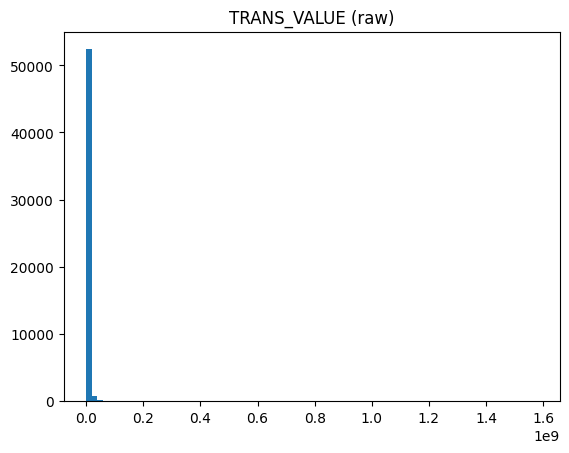

In [18]:
plt.figure()
plt.hist(y, bins=80)
plt.title("TRANS_VALUE (raw)")
plt.show()


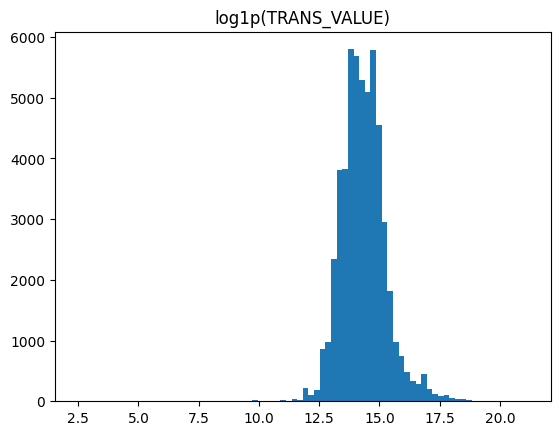

In [31]:

plt.figure()
plt.hist(np.log1p(y), bins=80)
plt.title("log1p(TRANS_VALUE)")
plt.show()


### Statistical analysis of TRANS_VALUE distribution
* The raw distribution of transaction values is highly right-skewed, with the majority of observations concentrated at lower price ranges and a small number of extremely large values extending the upper tail. This heavy-tailed behavior is clearly visible in the raw histogram, where most values cluster near zero relative to the full scale of the data.

* Such skewness is typical in real estate datasets, where standard residential transactions coexist with high-value luxury and commercial properties. However, this imbalance can negatively impact model training by disproportionately influencing loss functions and learned parameters.

* To address this, a logarithmic transformation (log1p(TRANS_VALUE)) was applied. The transformed distribution appears approximately symmetric and bell-shaped, indicating reduced skewness and stabilized variance. This transformation compresses extreme values while preserving relative ordering between transactions.

From a modeling perspective, the log-transformed target variable improves numerical stability, reduces sensitivity to outliers, and enables learning algorithms to better capture underlying relationships between features and transaction value.
The target variable exhibits extreme right skewness.
To stabilize variance and improve model learning, we model the target in
log-space using `log1p(TRANS_VALUE)`.

All evaluation metrics are later reported after inverse transformation
to preserve business interpretability.


### EDA

In [32]:
df_eda = df.copy()

In [33]:
df_eda["ylog"] = np.log1p(df_eda["TRANS_VALUE"].astype(float))
df_eda["MONTH"] = df_eda["INSTANCE_DATE"].dt.to_period("M").astype(str)

#### Transaction value by Month 


Transactions per month:
INSTANCE_DATE
2025-01    18987
2025-02    20317
2025-03    14177
Freq: M, Name: count, dtype: int64


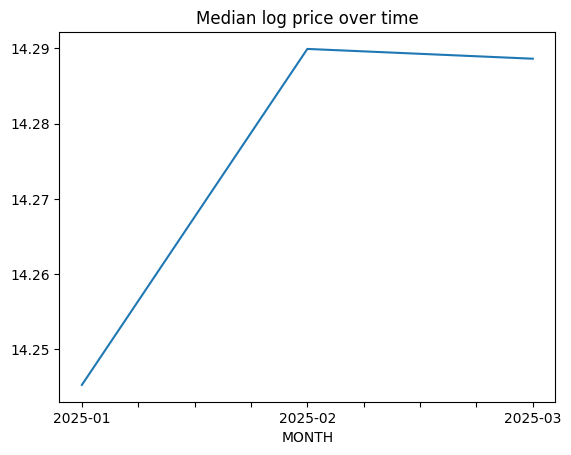

In [34]:
print("\nTransactions per month:")
per_month = (df["INSTANCE_DATE"].dt.to_period("M").value_counts().sort_index())

print(per_month)
trend = df_eda.groupby("MONTH")["ylog"].median()
trend.plot(kind="line", title="Median log price over time"); plt.show()

### Price Trend  by Area

In [35]:
df_eda[["AREA_EN", "ylog"]].isna().sum()


AREA_EN    0
ylog       0
dtype: int64

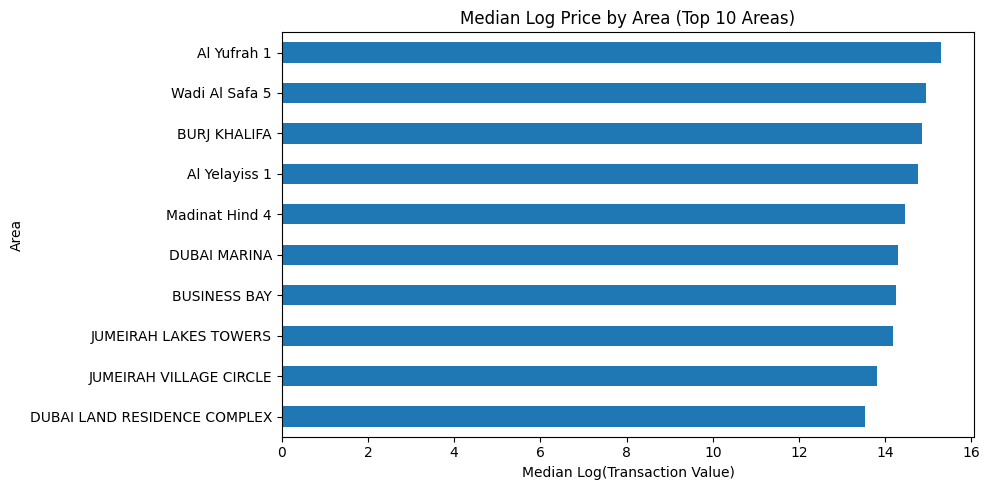

In [23]:
top_areas = df_eda["AREA_EN"].value_counts().head(10).index

area_price = (df_eda[df_eda["AREA_EN"].isin(top_areas)].groupby("AREA_EN")["ylog"].median().sort_values())

plt.figure(figsize=(10, 5))
area_price.plot(kind="barh")
plt.title("Median Log Price by Area (Top 10 Areas)")
plt.xlabel("Median Log(Transaction Value)")
plt.ylabel("Area")
plt.tight_layout()
plt.show()



#### Price Trend by Area (Top 10 Areas)
* This chart compares the median log-transformed transaction prices across the ten most active areas by transaction volume. The variation observed across areas highlights the strong influence of location on property valuation, even after applying logarithmic scaling to normalize price distribution.

* Premium locations such as Burj Khalifa, Dubai Marina, and Business Bay exhibit higher median prices, while residential clusters like Jumeirah Village Circle and Dubai Land Residence Complex show relatively lower median values. This spread confirms that area-level attributes capture meaningful pricing differences beyond property size or type.
#### Modeling Implication

* Given the consistent price separation across areas, AREA_EN is a high-signal categorical feature and should be retained during modeling, using appropriate encoding strategies to preserve location-specific effects

### Price Trend by property type

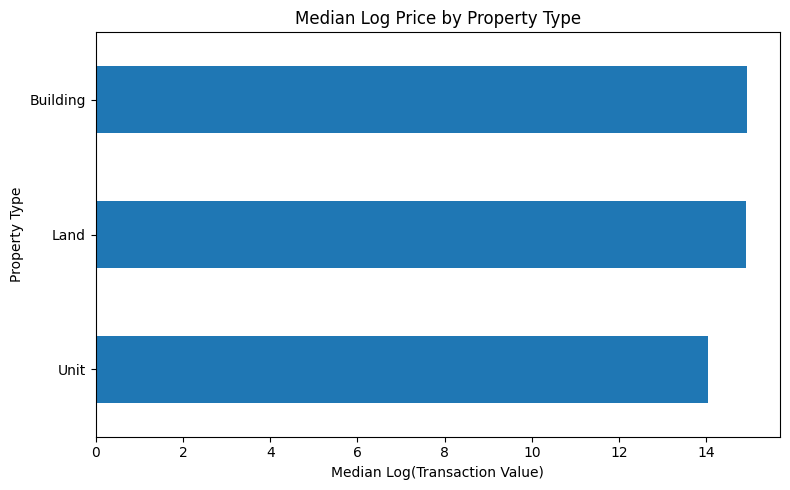

In [36]:
type_price = (df_eda.groupby("PROP_TYPE_EN")["ylog"].median().sort_values())

plt.figure(figsize=(8, 5))
type_price.plot(kind="barh")
plt.title("Median Log Price by Property Type")
plt.xlabel("Median Log(Transaction Value)")
plt.ylabel("Property Type")
plt.tight_layout()
plt.show()


#### Price Trend by property type

This plot shows the median log-transformed transaction price across different property types.
 Distinct price levels are observed between categories, indicating that property type plays a significant role in determining valuation. Units such as apartments and villas occupy different pricing bands, reflecting structural and usage-related differences.
* The monthly median price trend remains relatively stable over the observed period, with no abrupt increases or declines. 
* This suggests that price levels did not experience strong short-term volatility during the data window, supporting the use of time-based features without aggressive detrending.




### Price Trend by time

#### By Month

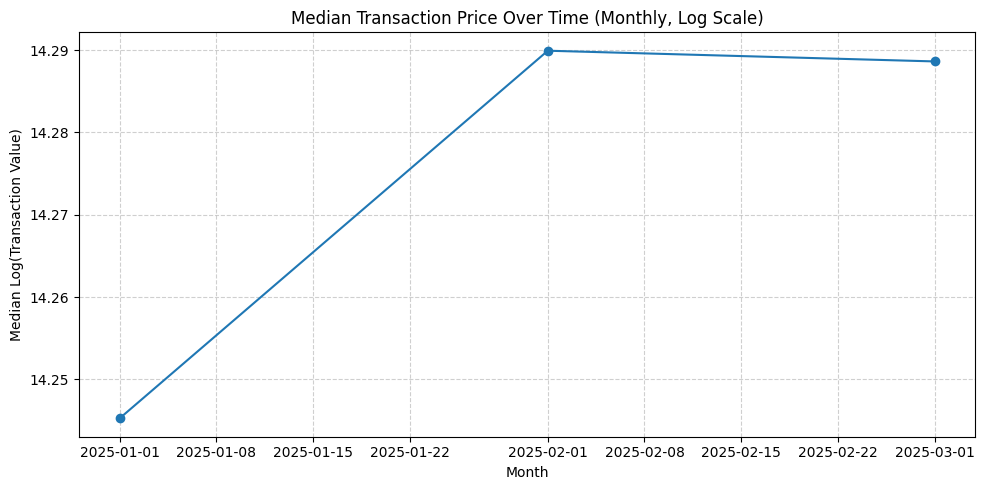

In [37]:
price_time = (df_eda.groupby(df_eda["INSTANCE_DATE"].dt.to_period("M"))["ylog"].median())
price_time.index = price_time.index.to_timestamp()
plt.figure(figsize=(10, 5))
plt.plot(price_time.index,price_time.values,marker="o",linestyle="-")
plt.title("Median Transaction Price Over Time (Monthly, Log Scale)")
plt.xlabel("Month")
plt.ylabel("Median Log(Transaction Value)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Price Trend Over Time (Monthly)

* This plot shows the median log-transformed transaction price aggregated by calendar month. Prices increase slightly from January to February and then remain largely stable into March. The absence of sharp rises or declines indicates that transaction prices did not experience significant short-term volatility during the observed period.

* The small dip in March should be interpreted cautiously, as the dataset only includes transactions up to March 21 and does not represent a full month.

#### By Week

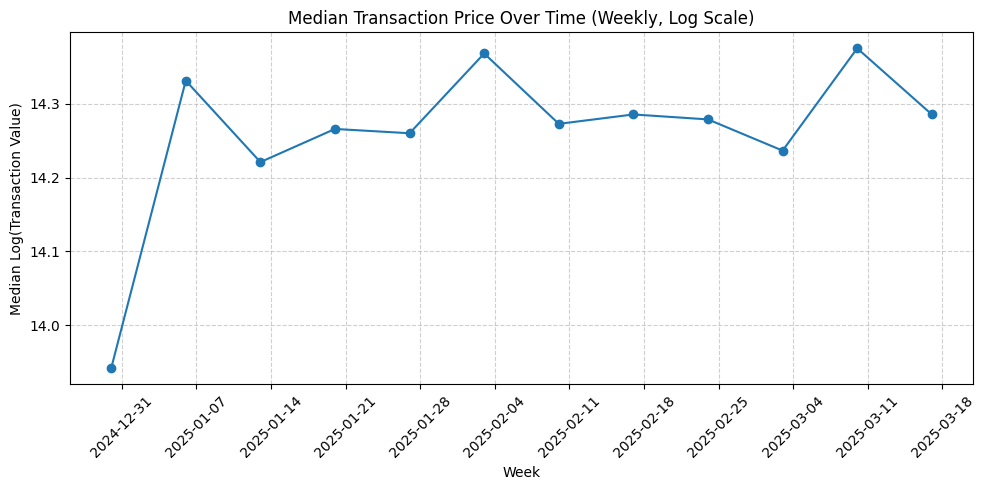

In [38]:
price_week = (
    df_eda
    .groupby(df_eda["INSTANCE_DATE"].dt.to_period("W"))["ylog"]
    .median()
)


price_week.index = price_week.index.to_timestamp()

plt.figure(figsize=(10, 5))
plt.plot(
    price_week.index,
    price_week.values,
    marker="o",
    linestyle="-"
)

plt.title("Median Transaction Price Over Time (Weekly, Log Scale)")
plt.xlabel("Week")
plt.ylabel("Median Log(Transaction Value)")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Price Trend Over Time (Weekly)

* This plot presents the weekly median of log-transformed transaction prices, with explicit weekly boundaries shown on the time axis. Prices fluctuate modestly from week to week, reflecting normal short-term market variation rather than abrupt price shifts.

* While individual weeks exhibit small increases or decreases, the overall price level remains stable across the observed period. The absence of sustained upward or downward trends suggests that weekly timing alone does not introduce strong price volatility.

### Off-Plan vs Ready Property Pricing

In [39]:
df_eda[[ "IS_OFFPLAN_EN","ylog"]].isna().sum()

IS_OFFPLAN_EN    0
ylog             0
dtype: int64

<Figure size 700x500 with 0 Axes>

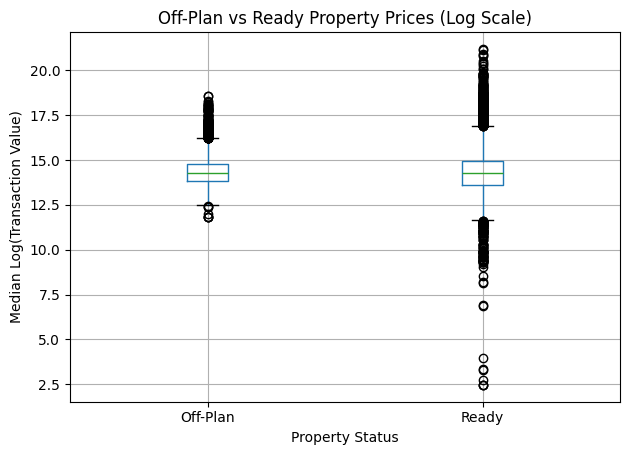

In [40]:
plt.figure(figsize=(7, 5))
df_eda.boxplot(column="ylog",by="IS_OFFPLAN_EN",grid=True)
plt.title("Off-Plan vs Ready Property Prices (Log Scale)")
plt.suptitle("")
plt.xlabel("Property Status")
plt.ylabel("Median Log(Transaction Value)")
plt.tight_layout()
plt.show()


#### Off-Plan vs Ready Property Pricing

* This boxplot compares the distribution of log-transformed transaction prices between off-plan and ready properties. Ready properties show a slightly higher median price and a wider spread, indicating greater variability in transaction values compared to off-plan properties.

* The tighter distribution observed for off-plan properties suggests more standardized pricing, likely influenced by predefined developer pricing and project-based sales. In contrast, ready properties exhibit broader dispersion, reflecting differences in location, property condition, and immediate usability.

Modeling Implication

* The observed difference in pricing distributions confirms that construction status (IS_OFFPLAN_EN) captures meaningful valuation information and should be retained as a categorical feature in the pricing model.

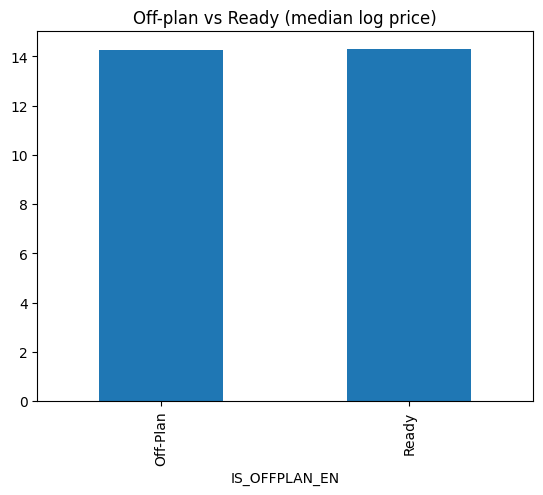

In [41]:

df_eda.groupby("IS_OFFPLAN_EN")["ylog"].median().plot(kind="bar", title="Off-plan vs Ready (median log price)"); plt.show()

#### Off-Plan vs Ready Property Pricing (Median Comparison)

* This bar chart compares the median log-transformed transaction price for off-plan and ready properties. Ready properties show a slightly higher median price compared to off-plan properties, reinforcing the presence of a valuation premium associated with completed construction and immediate usability.

* While the difference in median values is modest, it is consistent with the broader distributional patterns observed earlier, where ready properties also exhibited greater price variability. This suggests that construction status influences pricing, even when controlling for extreme values through log transformation.

### Freehold vs Leasehold Impact on Pricing

In [42]:
df_eda[[ "IS_FREE_HOLD_EN","ylog"]].isna().sum()

IS_FREE_HOLD_EN    0
ylog               0
dtype: int64

<Figure size 700x500 with 0 Axes>

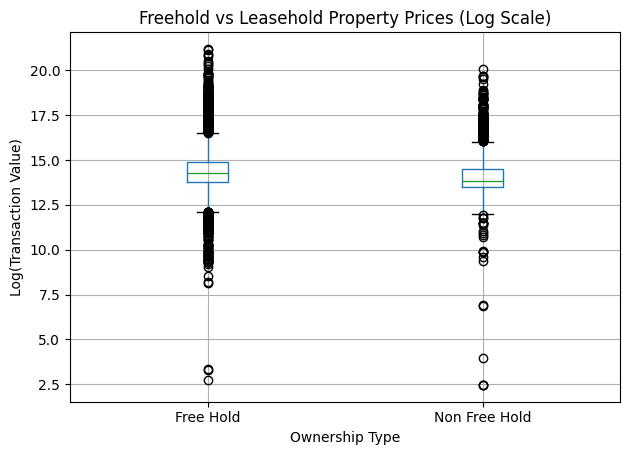

In [43]:
plt.figure(figsize=(7, 5))

df_eda.boxplot(column="ylog",by="IS_FREE_HOLD_EN",grid=True)

plt.title("Freehold vs Leasehold Property Prices (Log Scale)")
plt.suptitle("")
plt.xlabel("Ownership Type")
plt.ylabel("Log(Transaction Value)")
plt.tight_layout()
plt.show()


#### Freehold vs Leasehold Property Pricing

* This boxplot compares the distribution of log-transformed transaction prices between freehold and non-freehold (leasehold) properties. Freehold properties exhibit a slightly higher median transaction price, indicating a valuation premium associated with full ownership rights.

 * In addition, freehold properties show a broader price distribution, with a higher concentration of upper-range values. Non-freehold properties display a comparatively lower median and a narrower spread, reflecting more constrained valuation driven by time-bound ownership and contractual limitations.

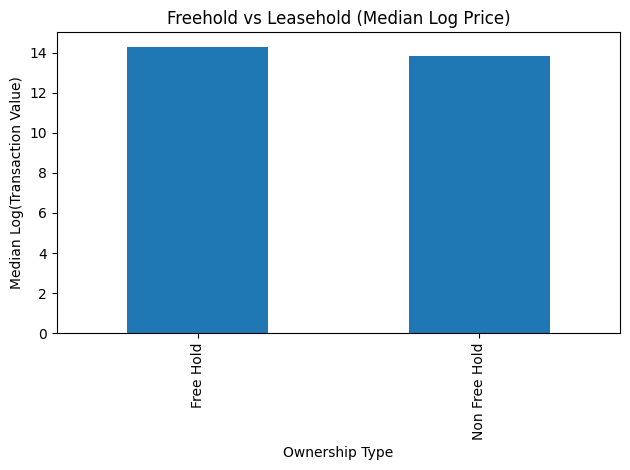

In [44]:
df_eda.groupby("IS_FREE_HOLD_EN")["ylog"].median().plot(kind="bar", title="Freehold vs Leasehold (Median Log Price)")
plt.xlabel("Ownership Type")
plt.ylabel("Median Log(Transaction Value)")
plt.tight_layout()
plt.show()


#### Freehold vs Leasehold Property Pricing (Median Comparison)

* This chart compares the median log-transformed transaction prices for freehold and non-freehold (leasehold) properties. Freehold properties exhibit a higher median price, indicating a consistent valuation premium associated with full ownership rights.

* Although the difference in median values is moderate, it aligns with the broader distributional patterns observed in the boxplot analysis, where freehold properties also showed greater price dispersion. This consistency reinforces the role of ownership structure as a meaningful determinant of property pricing.

#### Market Share: Freehold vs. Leasehold Transactions

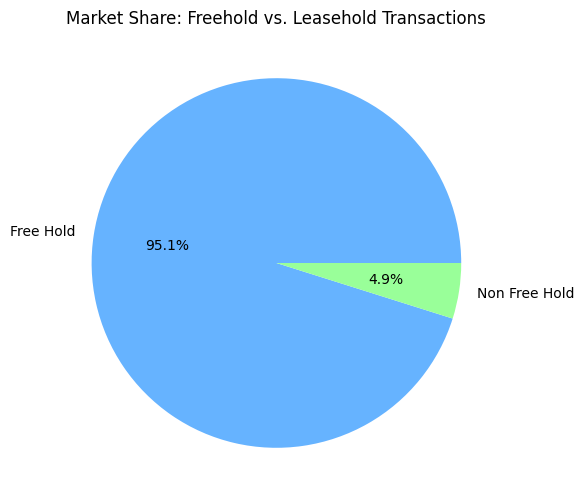

In [45]:
plt.figure(figsize=(8, 6))
df_eda['IS_FREE_HOLD_EN'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#99ff99'])
plt.title('Market Share: Freehold vs. Leasehold Transactions')
plt.ylabel('')
plt.show()

* This pie chart shows that the majority of transactions in the dataset are freehold properties, indicating higher market participation for full-ownership assets. The smaller share of leasehold transactions suggests that pricing patterns for leasehold properties are derived from a more limited transaction base.


#### Log-Price Distribution: Freehold vs. Leasehold

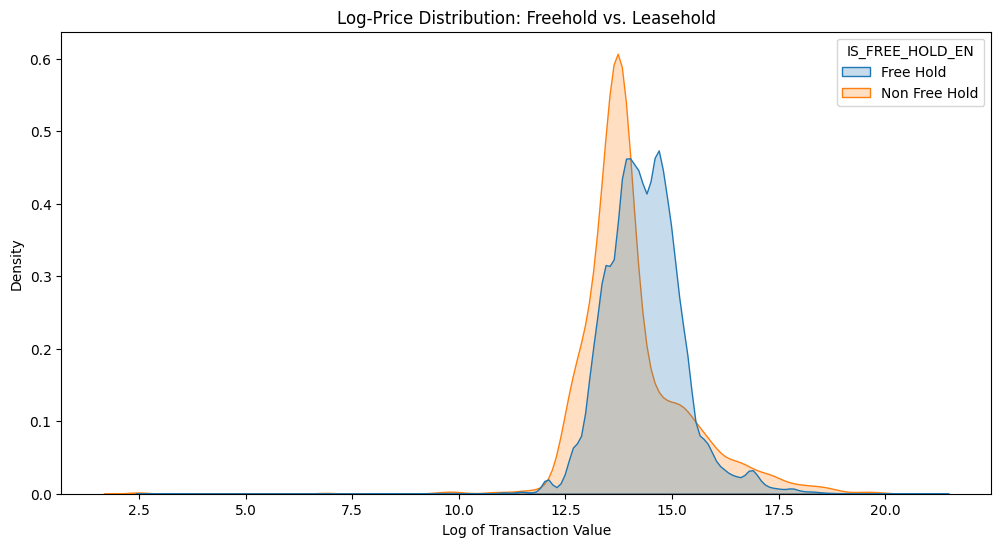

In [46]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_eda, x='ylog', hue='IS_FREE_HOLD_EN', fill=True, common_norm=False)
plt.title('Log-Price Distribution: Freehold vs. Leasehold')
plt.xlabel('Log of Transaction Value')
plt.ylabel('Density')
plt.show()


* The density plot highlights a rightward shift in the price distribution for freehold properties compared to leasehold properties, reinforcing the median and boxplot findings. 
* While the distributions overlap, freehold properties exhibit a higher concentration of upper-range prices.


### EDA continue

#### Procedure Type vs Price

<Figure size 3200x1600 with 0 Axes>

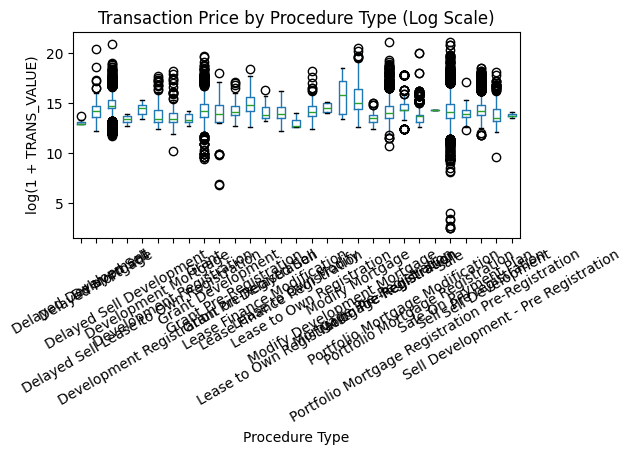

In [47]:
plt.figure(figsize=(32, 16))

df_eda.boxplot(
    column="ylog",
    by="PROCEDURE_EN",
    grid=False
)

plt.title("Transaction Price by Procedure Type (Log Scale)")
plt.suptitle("")
plt.xlabel("Procedure Type")
plt.ylabel("log(1 + TRANS_VALUE)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


#### Transaction Price by Procedure Type

* This boxplot compares the distribution of log-transformed transaction prices across different procedure types, such as sales, mortgages, and development-related registrations. While median prices across most procedures fall within a similar range, noticeable differences in spread and outliers are observed.

* Mortgage- and portfolio-related procedures exhibit wider price dispersion, reflecting variability in financed property values, whereas sale and development registrations show relatively more compact distributions. This indicates that transaction type influences price variability, even if central tendencies remain broadly comparable.

#### Usage Type vs Price

<Figure size 700x400 with 0 Axes>

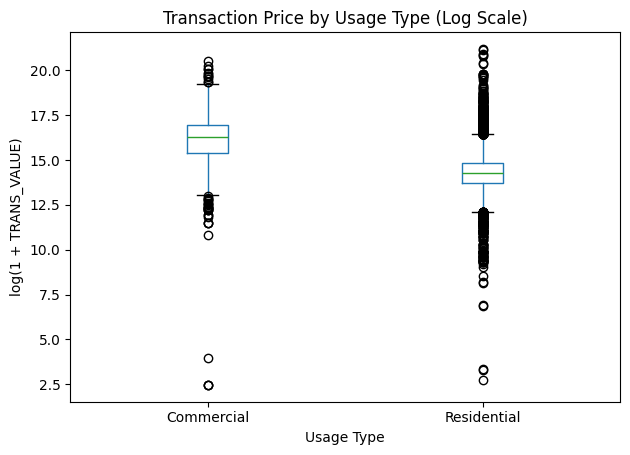

In [48]:
####
plt.figure(figsize=(7, 4))

df_eda.boxplot(
    column="ylog",
    by="USAGE_EN",
    grid=False
)

plt.title("Transaction Price by Usage Type (Log Scale)")
plt.suptitle("")
plt.xlabel("Usage Type")
plt.ylabel("log(1 + TRANS_VALUE)")
plt.tight_layout()
plt.show()


#### Transaction Price by Usage Type

* This boxplot compares the distribution of log-transformed transaction prices between residential and commercial properties. Commercial properties exhibit a higher median transaction price and a wider price range, indicating greater valuation potential and variability compared to residential properties.

* Residential properties show a lower median price with a relatively tighter distribution, reflecting more standardized pricing driven by housing demand and market regulations. The observed separation confirms that usage type is a meaningful structural factor influencing property valuation.



#### Transaction Price vs Actual Area

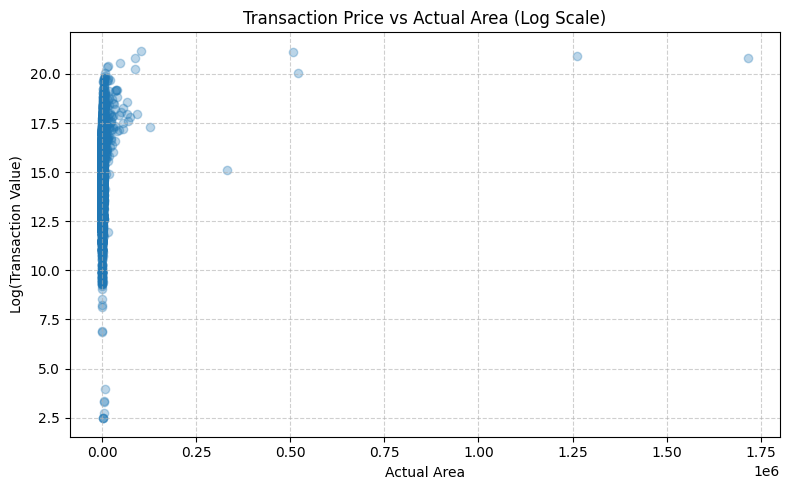

In [49]:
plt.figure(figsize=(8, 5))

plt.scatter(
    df_eda["ACTUAL_AREA"],
    df_eda["ylog"],
    alpha=0.3
)

plt.title("Transaction Price vs Actual Area (Log Scale)")
plt.xlabel("Actual Area")
plt.ylabel("Log(Transaction Value)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


##### Transaction Price vs Actual Area Analysis

* This scatter plot visualizes the relationship between property size (ACTUAL_AREA) and log-transformed transaction price. A general upward trend is visible, indicating that larger properties tend to command higher prices.

* However, there is substantial price variation for properties with similar area values, particularly at smaller and mid-range sizes. This dispersion suggests that while property size is an important pricing factor, it does not fully explain transaction value on its own. Location, property type, ownership structure, and market conditions also contribute significantly to price differences.

##### Modeling Implication

* ACTUAL_AREA should be included as a numerical feature in the pricing model, but its effect is best captured in combination with categorical features such as area, property type, and ownership status to account for the observed variability.

#### Daily trend of transaction per prop type

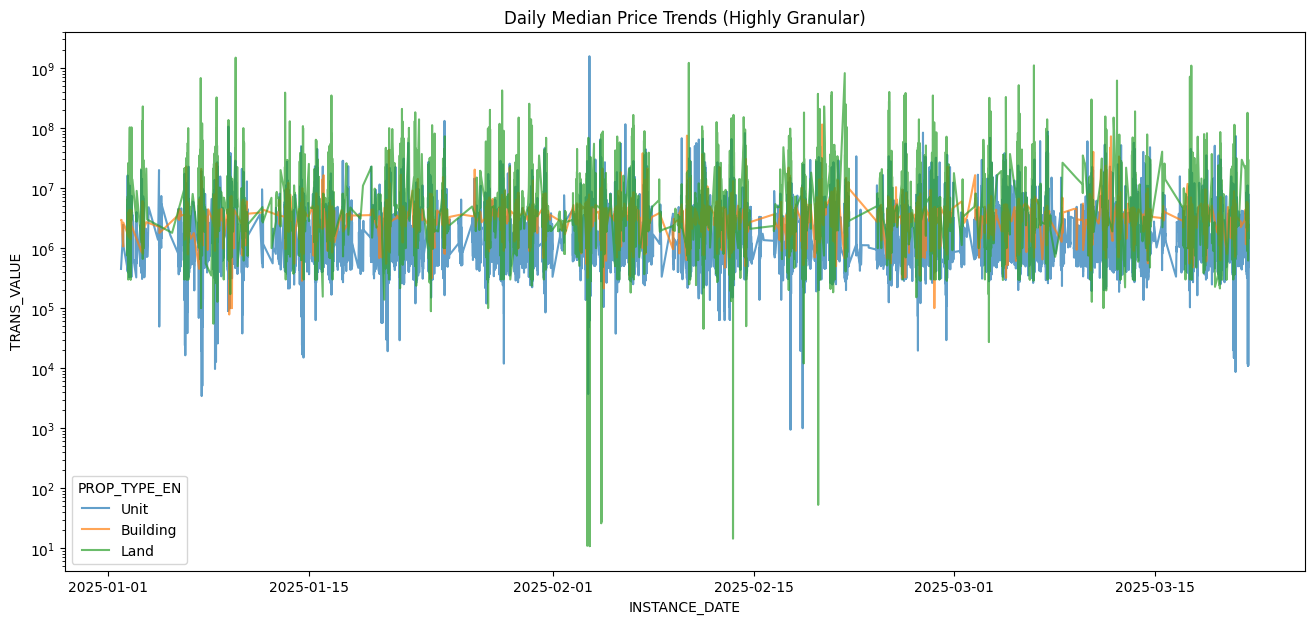

In [50]:
trend_daily = df_eda.groupby(['INSTANCE_DATE', 'PROP_TYPE_EN'])['TRANS_VALUE'].median().reset_index()

plt.figure(figsize=(16, 7))
sns.lineplot(data=trend_daily, x='INSTANCE_DATE', y='TRANS_VALUE', hue='PROP_TYPE_EN', alpha=0.7)
plt.title('Daily Median Price Trends (Highly Granular)')
plt.yscale('log')
plt.show()

#### Daily Price Trends by Property Type (High Granularity)

* This plot shows daily median transaction price trends across property types. At a daily level, the series exhibits high volatility and noise, with frequent spikes and drops across all categories, even after applying a logarithmic scale.

* The lack of a smooth or interpretable trend indicates that daily aggregation is too granular for stable price analysis in this dataset. Short-term fluctuations dominate the signal, making it difficult to extract meaningful temporal patterns by property type at this resolution.

#### EDA -EXTRA

<Figure size 800x400 with 0 Axes>

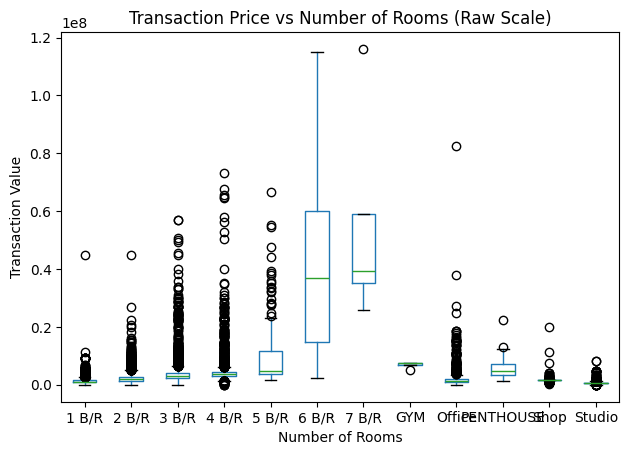

In [51]:
plt.figure(figsize=(8, 4))

df_eda.boxplot(
    column="TRANS_VALUE",
    by="ROOMS_EN",
    grid=False
)

plt.title("Transaction Price vs Number of Rooms (Raw Scale)")
plt.suptitle("")
plt.xlabel("Number of Rooms")
plt.ylabel("Transaction Value")
plt.tight_layout()
plt.show()


## Outlier Handling Strategy

Extreme transaction values are common in real estate data and often represent
legitimate high-value properties rather than data errors.

Instead of aggressively removing outliers, we rely on:
- log-scale modeling
- robust tree-based models

This approach preserves valuable information while reducing the influence
of extreme values during training.


## Handling Missing Values and feature engineering

In [52]:
df.isna().sum().sort_values(ascending=False).head(8)

MASTER_PROJECT_EN      53382
NEAREST_MALL_EN        25085
NEAREST_METRO_EN       24665
NEAREST_LANDMARK_EN    18553
PARKING                15746
ROOMS_EN               10023
PROJECT_EN              7955
PROP_SB_TYPE_EN         2372
dtype: int64

In [53]:
df["ROOMS_EN"].value_counts()

ROOMS_EN
1 B/R        15592
2 B/R        10611
Studio        8022
3 B/R         5538
4 B/R         2328
Office         892
Shop           216
5 B/R          197
PENTHOUSE       41
6 B/R           13
7 B/R            4
GYM              4
Name: count, dtype: int64

In [54]:
def parse_rooms(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip().lower()
    if "studio" in s:
        return 0.0
    m = re.search(r"(\d+)", s)
    return float(m.group(1)) if m else np.nan

In [55]:
df.groupby(["PROP_TYPE_EN", "ROOMS_EN"]).size().reset_index(name="count").sort_values(["PROP_TYPE_EN", "count"], ascending=[True, False])

,PROP_TYPE_EN,ROOMS_EN,count
2,Building,3 B/R,2602
3,Building,4 B/R,2057
1,Building,2 B/R,442
4,Building,5 B/R,142
0,Building,1 B/R,62
5,Building,6 B/R,5
6,Building,7 B/R,3
7,Unit,1 B/R,15530
8,Unit,2 B/R,10169
18,Unit,Studio,8022


In [47]:
df["PARKING"].value_counts()

PARKING
1           18053
2            1359
1  0          281
EU            276
3              87
            ...  
14 3B 01        1
8-G-13          1
14GB25          1
14GA24          1
14 2B 24        1
Name: count, Length: 7825, dtype: int64

In [56]:

def parse_parking(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan


In [149]:
df.columns

Index(['TRANSACTION_NUMBER', 'INSTANCE_DATE', 'GROUP_EN', 'PROCEDURE_EN', 'IS_OFFPLAN_EN', 'IS_FREE_HOLD_EN', 'USAGE_EN', 'AREA_EN',
       'PROP_TYPE_EN', 'PROP_SB_TYPE_EN', 'TRANS_VALUE', 'PROCEDURE_AREA', 'ACTUAL_AREA', 'ROOMS_EN', 'PARKING', 'NEAREST_METRO_EN',
       'NEAREST_MALL_EN', 'NEAREST_LANDMARK_EN', 'TOTAL_BUYER', 'TOTAL_SELLER', 'MASTER_PROJECT_EN', 'PROJECT_EN'],
      dtype='object')

* The dataset is split into training, validation, and test sets before applying any feature engineering steps that depend on global data statistics or target-related information. 
* This separation ensures that the model does not gain indirect access to information from the validation or test sets during training, thereby preventing data leakage and preserving the integrity of performance evaluation.



## Time-Based Train–Validation–Test Split
* The dataset was split into training, validation, and test sets using a time-based strategy rather than random sampling. Transactions were first sorted chronologically by `INSTANCE_DATE`, after which the most recent 7 days were reserved for the test set and the preceding 7 days for validation. All earlier records were used for training.

* This approach reflects the real-world deployment scenario, where a pricing model is trained on historical data and evaluated on future transactions. By preserving temporal order, the split prevents information leakage from future observations into the training process and ensures that model performance metrics represent true forward-looking generalization.

### Why Time-Based Splitting Is Necessary Here
* Real-estate transaction data exhibits temporal patterns driven by market trends, seasonality, and policy changes. A random split would mix past and future transactions across sets, potentially allowing the model to learn patterns that would not be available at prediction time. Time-based splitting avoids this issue and provides a more realistic and robust evaluation of model performance.


In [57]:
df = df.sort_values("INSTANCE_DATE").reset_index(drop=True)
df["DATE"] = df["INSTANCE_DATE"].dt.date
unique_days = sorted(df["DATE"].unique())

test_days = set(unique_days[-7:])
val_days  = set(unique_days[-14:-7])

test_df  = df[df["DATE"].isin(test_days)].copy()
val_df   = df[df["DATE"].isin(val_days)].copy()
train_df = df[~df["DATE"].isin(test_days | val_days)].copy()

print("Train:", min(train_df["DATE"]), "->", max(train_df["DATE"]), len(train_df))
print("Val  :", min(val_df["DATE"]), "->", max(val_df["DATE"]), len(val_df))
print("Test :", min(test_df["DATE"]), "->", max(test_df["DATE"]), len(test_df))


Train: 2025-01-01 -> 2025-03-07 44235
Val  : 2025-03-08 -> 2025-03-14 4613
Test : 2025-03-15 -> 2025-03-21 4633


## Metrics helpers




In [58]:


def mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), 1e-6)
    return np.mean(np.abs((y_true - y_pred)/denom))*100

def eval_metrics(name, y_true_raw, pred_raw):
    r2 = r2_score(np.log1p(y_true_raw), np.log1p(pred_raw))
    mae = mean_absolute_error(y_true_raw, pred_raw)
    mp = mape(y_true_raw, pred_raw)
    print(f"{name} | R2(log): {r2:.4f} | MAE: {mae:,.0f} | MAPE%: {mp:.2f}")


## Baseline Models

Baseline models are evaluated to establish a reference level of performance
and to understand how much predictive power comes from simple heuristics,
such as global or location-based medians.

These baselines help contextualize the performance gains of more complex models.


In [52]:
y_train = train_df["TRANS_VALUE"].astype(float).values
y_val   = val_df["TRANS_VALUE"].astype(float).values
y_test  = test_df["TRANS_VALUE"].astype(float).values

pred_val  = np.full_like(y_val,  np.median(y_train), dtype=float)
pred_test = np.full_like(y_test, np.median(y_train), dtype=float)

eval_metrics("BASELINE Global Median (VAL)",  y_val,  pred_val)
eval_metrics("BASELINE Global Median (TEST)", y_test, pred_test)

grp = train_df.groupby(["AREA_EN","PROP_TYPE_EN"])["TRANS_VALUE"].median()

def pred_area_type(df_):
    keys = list(zip(df_["AREA_EN"], df_["PROP_TYPE_EN"]))
    return np.array([grp.get(k, np.median(y_train)) for k in keys], dtype=float)

pred_val  = pred_area_type(val_df)
pred_test = pred_area_type(test_df)

eval_metrics("BASELINE Area+Type Median (VAL)",  y_val,  pred_val)
eval_metrics("BASELINE Area+Type Median (TEST)", y_test, pred_test)


BASELINE Global Median (VAL) | R2(log): -0.0161 | MAE: 2,277,995 | MAPE%: 73.34
BASELINE Global Median (TEST) | R2(log): -0.0071 | MAE: 2,651,480 | MAPE%: 133.24
BASELINE Area+Type Median (VAL) | R2(log): 0.6035 | MAE: 1,534,482 | MAPE%: 47.75
BASELINE Area+Type Median (TEST) | R2(log): 0.5088 | MAE: 1,722,648 | MAPE%: 85.25


## Feature Engineering

Features are engineered to capture key drivers of real estate prices, including:
- structural attributes (area, rooms, parking)
- temporal effects
- location-based signals

All feature engineering steps are designed to avoid target leakage and to
remain compatible with real-world inference.


In [59]:
def build_features(df):
    d = df.copy()

    d["ACTUAL_AREA"] = pd.to_numeric(d.get("ACTUAL_AREA"), errors="coerce")
    d["PROCEDURE_AREA"] = pd.to_numeric(d.get("PROCEDURE_AREA"), errors="coerce")

    d["ROOMS_COUNT"] = d.get("ROOMS_EN").apply(parse_rooms) if "ROOMS_EN" in d.columns else np.nan
    d["PARKING_COUNT"] = d.get("PARKING").apply(parse_parking) if "PARKING" in d.columns else np.nan

    d["AREA_RATIO"] = d["ACTUAL_AREA"] / (d["PROCEDURE_AREA"] + 1e-6)
    dt = d["INSTANCE_DATE"]
    d["MONTH"] = dt.dt.month
    d["DOW"] = dt.dt.dayofweek
    d["MONTH_SIN"] = np.sin(2*np.pi*d["MONTH"]/12)
    d["MONTH_COS"] = np.cos(2*np.pi*d["MONTH"]/12)
    d["DOW_SIN"] = np.sin(2*np.pi*d["DOW"]/7)
    d["DOW_COS"] = np.cos(2*np.pi*d["DOW"]/7)
    for c in ["NEAREST_METRO_EN","NEAREST_MALL_EN","NEAREST_LANDMARK_EN","PROJECT_EN"]:
        if c in d.columns:
            d[f"{c}_MISSING"] = d[c].isna().astype(int)

    return d


### High-cardinality categorical variables  Handling?
High-cardinality categorical variables ((projects, areas, landmarks) were handled using CatBoost’s native categorical encoding and target-based aggregation features to avoid dimensional explosion and leakage-prone one-hot encodings.

In [54]:
train_df = build_features(train_df)
val_df   = build_features(val_df)
test_df  = build_features(test_df)

In [55]:

print("Train shape:", train_df.shape, "Val shape:", val_df.shape, "Test shape:", test_df.shape)

Train shape: (44235, 36) Val shape: (4613, 36) Test shape: (4633, 36)


## Segment-Based Data Split (MAIN vs LAND)

Exploratory error analysis showed that land transactions follow fundamentally
different pricing dynamics compared to residential units and buildings.

To improve robustness and generalization, the dataset is segmented into:
- MAIN: Units and Buildings
- LAND: Land transactions

Separate models are later trained for each segment.


In [60]:
train_land = train_df[train_df["PROP_TYPE_EN"] == "Land"].copy()
val_land   = val_df[val_df["PROP_TYPE_EN"] == "Land"].copy()
test_land  = test_df[test_df["PROP_TYPE_EN"] == "Land"].copy()

train_main = train_df[train_df["PROP_TYPE_EN"] != "Land"].copy()
val_main   = val_df[val_df["PROP_TYPE_EN"] != "Land"].copy()
test_main  = test_df[test_df["PROP_TYPE_EN"] != "Land"].copy()

print("LAND:", len(train_land), len(val_land), len(test_land))
print("MAIN:", len(train_main), len(val_main), len(test_main))


LAND: 7801 748 730
MAIN: 36434 3865 3903


## Leakage-Safe Aggregate Price Priors (MAIN Segment)

To capture market structure, train-only aggregate price priors are created for
the MAIN segment.

These features encode historical pricing behavior at different geographic and
property-type levels (e.g., area, project), while strictly avoiding data leakage
by computing aggregates using training data only.

Aggregate priors were validated to improve generalization for dense residential
segments and are intentionally not applied to LAND due to sparsity.


In [61]:
def add_agg_features(train_df, apply_df, group_cols, target_col="TRANS_VALUE"):
    tr = train_df.copy()
    tr["_ylog"] = np.log1p(tr[target_col].astype(float))

    stats = tr.groupby(group_cols)["_ylog"].agg(["median","mean","count"]).reset_index()
    prefix = "AGG_" + "_".join(group_cols)

    stats = stats.rename(columns={
        "median": f"{prefix}_ylog_median",
        "mean":   f"{prefix}_ylog_mean",
        "count":  f"{prefix}_count"
    })

    out = apply_df.merge(stats, on=group_cols, how="left")

    global_med = tr["_ylog"].median()
    global_mean = tr["_ylog"].mean()

    out[f"{prefix}_ylog_median"] = out[f"{prefix}_ylog_median"].fillna(global_med)
    out[f"{prefix}_ylog_mean"]   = out[f"{prefix}_ylog_mean"].fillna(global_mean)
    out[f"{prefix}_count"]       = out[f"{prefix}_count"].fillna(0).astype(float)
    out[f"{prefix}_logcount"]    = np.log1p(out[f"{prefix}_count"])

    return out

for cols in [["AREA_EN"], ["PROJECT_EN"], ["AREA_EN","PROP_TYPE_EN"]]:
    train_main = add_agg_features(train_main, train_main, cols)
    val_main   = add_agg_features(train_main, val_main, cols)
    test_main  = add_agg_features(train_main, test_main, cols)




## Feature Matrix Construction and Cleaning Utilities

This section defines shared helper functions to:
- separate features (X) and targets (y)
- apply consistent preprocessing for tree-based models
- handle missing values and data type coercion

Centralizing this logic ensures reproducibility and prevents subtle preprocessing
differences between models.


In [62]:
drop_cols = ["TRANS_VALUE","TRANSACTION_NUMBER","INSTANCE_DATE","DATE","MASTER_PROJECT_EN"]

def build_xy(df_):
    X = df_.drop(columns=drop_cols, errors="ignore").copy()
    y_raw = df_["TRANS_VALUE"].astype(float).values
    y_log = np.log1p(y_raw)
    return X, y_raw, y_log

def clean_for_tree(X_train, X_val, X_test):
    cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    num_cols = [c for c in X_train.columns if c not in cat_cols]

    for c in cat_cols:
        X_train[c] = X_train[c].fillna("__MISSING__").astype(str)
        X_val[c]   = X_val[c].fillna("__MISSING__").astype(str)
        X_test[c]  = X_test[c].fillna("__MISSING__").astype(str)

    for c in num_cols:
        X_train[c] = pd.to_numeric(X_train[c], errors="coerce")
        X_val[c]   = pd.to_numeric(X_val[c], errors="coerce")
        X_test[c]  = pd.to_numeric(X_test[c], errors="coerce")

    med = X_train[num_cols].median()
    X_train[num_cols] = X_train[num_cols].fillna(med)
    X_val[num_cols]   = X_val[num_cols].fillna(med)
    X_test[num_cols]  = X_test[num_cols].fillna(med)

    return X_train, X_val, X_test, cat_cols, num_cols, med


## Model Training — MAIN Segment (CatBoost)

CatBoost is used as the primary model for the MAIN segment due to its native
support for high-cardinality categorical features and strong generalization
performance on tabular data.

The model is trained in log-space using a validation set for early stopping.
Final performance is reported on unseen test data.


In [63]:
X_train_m, y_train_m_raw, y_train_m = build_xy(train_main)
X_val_m,   y_val_m_raw,   y_val_m   = build_xy(val_main)
X_test_m,  y_test_m_raw,  y_test_m  = build_xy(test_main)


In [65]:
X_train_m, X_val_m, X_test_m, cat_cols_m, num_cols_m, med_m = clean_for_tree(X_train_m, X_val_m, X_test_m)
cat_idx_m = [X_train_m.columns.get_loc(c) for c in cat_cols_m]

main_model = CatBoostRegressor(
    loss_function="RMSE",
    depth=8,
    learning_rate=0.05,
    iterations=4000,
    random_seed=42,
    verbose=200
)

main_model.fit(
    X_train_m, y_train_m,
    cat_features=cat_idx_m,
    eval_set=(X_val_m, y_val_m),
    use_best_model=True
)

pred_val_m  = np.expm1(main_model.predict(X_val_m))
pred_test_m = np.expm1(main_model.predict(X_test_m))

eval_metrics("MAIN CatBoost (VAL)",  y_val_m_raw,  pred_val_m)
eval_metrics("MAIN CatBoost (TEST)", y_test_m_raw, pred_test_m)


C:\Users\Ganesh L\AppData\Local\Temp\ipykernel_35668\3478665846.py:10: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()


0:	learn: 0.7517339	test: 0.7469167	best: 0.7469167 (0)	total: 221ms	remaining: 14m 42s
200:	learn: 0.2415021	test: 0.2240806	best: 0.2240806 (200)	total: 16.6s	remaining: 5m 13s
400:	learn: 0.2241295	test: 0.2136042	best: 0.2136042 (400)	total: 32.8s	remaining: 4m 54s
600:	learn: 0.2131451	test: 0.2086311	best: 0.2086311 (600)	total: 49.3s	remaining: 4m 39s
800:	learn: 0.2048696	test: 0.2054798	best: 0.2054360 (797)	total: 1m 5s	remaining: 4m 20s
1000:	learn: 0.1985059	test: 0.2031550	best: 0.2031519 (999)	total: 1m 21s	remaining: 4m 5s
1200:	learn: 0.1926042	test: 0.2007441	best: 0.2007441 (1200)	total: 1m 38s	remaining: 3m 49s
1400:	learn: 0.1874643	test: 0.1997219	best: 0.1997028 (1394)	total: 1m 54s	remaining: 3m 33s
1600:	learn: 0.1830083	test: 0.1984660	best: 0.1984184 (1581)	total: 2m 11s	remaining: 3m 17s
1800:	learn: 0.1790360	test: 0.1977097	best: 0.1977089 (1798)	total: 2m 28s	remaining: 3m 1s
2000:	learn: 0.1749853	test: 0.1969285	best: 0.1969240 (1998)	total: 2m 45s	remai

##  Model Training — LAND Segment (CatBoost)

Land transactions exhibit higher volatility and sparser data.
A separate, simpler CatBoost model is trained for this segment without aggregate
priors to reduce overfitting.

This segmented approach improves robustness and reflects real-world pricing
behavior for land assets.


In [66]:
X_train_l, y_train_l_raw, y_train_l = build_xy(train_land)
X_val_l,   y_val_l_raw,   y_val_l   = build_xy(val_land)
X_test_l,  y_test_l_raw,  y_test_l  = build_xy(test_land)

X_train_l, X_val_l, X_test_l, cat_cols_l, num_cols_l, med_l = clean_for_tree(X_train_l, X_val_l, X_test_l)
cat_idx_l = [X_train_l.columns.get_loc(c) for c in cat_cols_l]

land_model = CatBoostRegressor(
    loss_function="RMSE",
    depth=6,
    learning_rate=0.05,
    iterations=2500,
    random_seed=42,
    verbose=200
)

land_model.fit(
    X_train_l, y_train_l,
    cat_features=cat_idx_l,
    eval_set=(X_val_l, y_val_l),
    use_best_model=True
)

pred_val_l  = np.expm1(land_model.predict(X_val_l))
pred_test_l = np.expm1(land_model.predict(X_test_l))

eval_metrics("LAND CatBoost (VAL)",  y_val_l_raw,  pred_val_l)
eval_metrics("LAND CatBoost (TEST)", y_test_l_raw, pred_test_l)


C:\Users\Ganesh L\AppData\Local\Temp\ipykernel_35668\3478665846.py:10: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()


0:	learn: 1.2687552	test: 1.1072792	best: 1.1072792 (0)	total: 33.5ms	remaining: 1m 23s
200:	learn: 0.4987977	test: 0.4696369	best: 0.4696224 (198)	total: 7.79s	remaining: 1m 29s
400:	learn: 0.4295090	test: 0.4576034	best: 0.4573528 (397)	total: 15.5s	remaining: 1m 20s
600:	learn: 0.3896478	test: 0.4511984	best: 0.4508738 (596)	total: 23.2s	remaining: 1m 13s
800:	learn: 0.3624876	test: 0.4473136	best: 0.4467608 (795)	total: 30.9s	remaining: 1m 5s
1000:	learn: 0.3426371	test: 0.4462441	best: 0.4455243 (849)	total: 38.8s	remaining: 58.1s
1200:	learn: 0.3249933	test: 0.4437211	best: 0.4436075 (1190)	total: 46.7s	remaining: 50.5s
1400:	learn: 0.3056056	test: 0.4412177	best: 0.4412061 (1398)	total: 54.6s	remaining: 42.8s
1600:	learn: 0.2921164	test: 0.4366431	best: 0.4364907 (1586)	total: 1m 2s	remaining: 35s
1800:	learn: 0.2812089	test: 0.4338257	best: 0.4338257 (1800)	total: 1m 10s	remaining: 27.3s
2000:	learn: 0.2714250	test: 0.4326378	best: 0.4325404 (1992)	total: 1m 17s	remaining: 19.4

## Price-Band Error Analysis (MAIN Segment)

Model performance is analyzed across price bands to identify systematic
differences in prediction accuracy.

This analysis helps verify that the model performs consistently across low,
mid, and high price ranges and highlights expected challenges in luxury segments.


In [64]:
band = pd.qcut(y_test_m_raw, q=5, duplicates="drop")
band_df = pd.DataFrame({"band": band.astype(str), "y_true": y_test_m_raw, "y_pred": pred_test_m})
band_metrics = band_df.groupby("band").apply(
    lambda g: pd.Series({
        "count": len(g),
        "MAE": mean_absolute_error(g["y_true"], g["y_pred"]),
        "MAPE%": mape(g["y_true"], g["y_pred"])
    })
).reset_index()

band_metrics


,band,count,MAE,MAPE%
0,"(1160000.0, 1750000.0]",782.0,167574.801512,11.678855
1,"(1750000.0, 2900000.0]",778.0,261709.237904,11.517506
2,"(2900000.0, 73375000.0]",779.0,789181.864826,12.929933
3,"(737984.0, 1160000.0]",782.0,114924.734328,12.016140
4,"(8623.529, 737984.0]",782.0,94052.152051,47.876480


## Model Comparison Across Algorithms

Multiple gradient boosting models are evaluated under the same data split,
feature set, and evaluation metrics:
- CatBoost (native categorical handling)
- LightGBM (one-hot encoding)
- XGBoost (one-hot encoding)

The final model is selected based on test-set generalization performance rather
than validation accuracy alone.


In [65]:


def sanitize_cols(cols):
    out = []
    for c in cols:
        out.append(re.sub(r'[^A-Za-z0-9_]+', '_', str(c))[:200])
    return out

rows = []

def add_row(model_name, split, y_true_raw, pred_log):
    pred = np.expm1(pred_log)
    rows.append({
        "Model": model_name,
        "Split": split,
        "R2_log": float(r2_score(np.log1p(y_true_raw), np.log1p(pred))),
        "MAE": float(mean_absolute_error(y_true_raw, pred)),
        "MAPE_%": float(mape(y_true_raw, pred))
    })


add_row("CatBoost (native cat)", "VAL",  y_val_m_raw,  main_model.predict(X_val_m))
add_row("CatBoost (native cat)", "TEST", y_test_m_raw, main_model.predict(X_test_m))


X_train_oh = pd.get_dummies(X_train_m, columns=cat_cols_m, drop_first=False)
X_val_oh   = pd.get_dummies(X_val_m,   columns=cat_cols_m, drop_first=False)
X_test_oh  = pd.get_dummies(X_test_m,  columns=cat_cols_m, drop_first=False)



def sanitize_cols(cols):
    out = []
    for c in cols:
        out.append(re.sub(r'[^A-Za-z0-9_]+', '_', str(c))[:200])
    return out

def dedup_columns(df_):

    df_ = df_.copy()
    df_ = df_.loc[:, ~df_.columns.duplicated()]
    return df_


X_train_oh.columns = sanitize_cols(X_train_oh.columns)
X_val_oh.columns   = sanitize_cols(X_val_oh.columns)
X_test_oh.columns  = sanitize_cols(X_test_oh.columns)

X_train_oh = dedup_columns(X_train_oh)
X_val_oh   = dedup_columns(X_val_oh)
X_test_oh  = dedup_columns(X_test_oh)

X_val_oh  = X_val_oh.reindex(columns=X_train_oh.columns, fill_value=0)
X_test_oh = X_test_oh.reindex(columns=X_train_oh.columns, fill_value=0)

print("One-hot shapes:", X_train_oh.shape, X_val_oh.shape, X_test_oh.shape)
print("Duplicate cols in train?", X_train_oh.columns.duplicated().any())

lgbm = lgb.LGBMRegressor(
    n_estimators=6000,
    learning_rate=0.03,
    num_leaves=128,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42
)
lgbm.fit(
    X_train_oh, y_train_m,
    eval_set=[(X_val_oh, y_val_m)],
    eval_metric="l2",
    callbacks=[lgb.early_stopping(stopping_rounds=250, verbose=False)]
)
add_row("LightGBM (one-hot)", "VAL",  y_val_m_raw,  lgbm.predict(X_val_oh))
add_row("LightGBM (one-hot)", "TEST", y_test_m_raw, lgbm.predict(X_test_oh))


xgb = XGBRegressor(
    n_estimators=6000,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_oh, y_train_m, eval_set=[(X_val_oh, y_val_m)], verbose=False)
add_row("XGBoost (one-hot)", "VAL",  y_val_m_raw,  xgb.predict(X_val_oh))
add_row("XGBoost (one-hot)", "TEST", y_test_m_raw, xgb.predict(X_test_oh))

pd.DataFrame(rows).sort_values(["Split","R2_log"], ascending=[True, False])


One-hot shapes: (36434, 8757) (3865, 8757) (3903, 8757)
Duplicate cols in train? False
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3478
[LightGBM] [Info] Number of data points in the train set: 36434, number of used features: 332
[LightGBM] [Info] Start training from score 14.176196


,Model,Split,R2_log,MAE,MAPE_%
1,CatBoost (native cat),TEST,0.892577,285125.769849,19.216482
3,LightGBM (one-hot),TEST,0.881544,276885.158998,21.924851
5,XGBoost (one-hot),TEST,0.881276,278200.040604,22.084477
0,CatBoost (native cat),VAL,0.938427,289064.892257,12.549296
4,XGBoost (one-hot),VAL,0.934264,282941.867333,12.642297
2,LightGBM (one-hot),VAL,0.933803,301278.091773,12.922438


### Feature importance

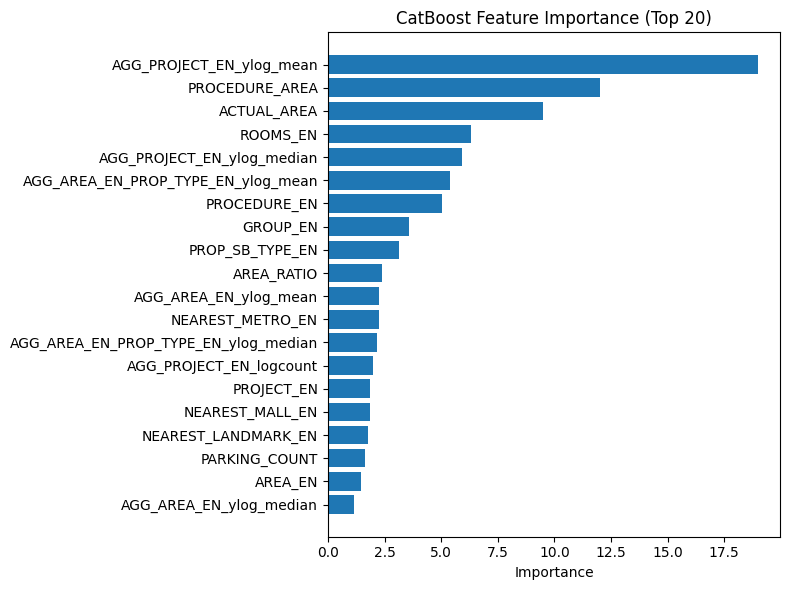

In [66]:
fi = main_model.get_feature_importance()
features = X_train_m.columns

fi_df = (
    pd.DataFrame({"feature": features, "importance": fi})
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8, 6))
plt.barh(fi_df.head(20)["feature"][::-1],
         fi_df.head(20)["importance"][::-1])
plt.title("CatBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


#### This plot shows the most influential features learned by the CatBoost model.
* The feature importance plot highlights the key drivers of transaction price predictions learned by the CatBoost model. Aggregated location- and project-level features, such as project-level mean log price and area–property-type price summaries, emerge as the most influential predictors. This indicates that local market context and historical pricing patterns at the project and community level play a central role in property valuation.

* Structural attributes, including registered area (`PROCEDURE_AREA`), actual built-up area (`ACTUAL_AREA`), and number of rooms, also contribute significantly, confirming the importance of physical property characteristics. Categorical descriptors such as procedure type, property group, and sub-type provide additional explanatory power by capturing transaction context and usage patterns.

* Proximity-based features (nearest metro, landmark, and mall) and derived ratio features further refine predictions, reflecting accessibility and locational desirability. Overall, the model balances granular property attributes with aggregated market signals, aligning well with real-world real estate pricing behavior.


## Model Explainability (SHAP Analysis)

SHAP analysis is used to interpret model predictions and identify the most
important drivers of transaction prices.

This step improves transparency, validates model behavior against domain
intuition, and supports trust in downstream usage.


In [ ]:
!pip install -q shap
#!pip install notebook ipykernel


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached notebook-7.5.3-py3-none-any.whl.metadata (10 kB)
  Using cached jupyter_server-2.17.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached jupyterlab_server-2.28.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached jupyterlab-4.5.3-py3-none-any.whl.metadata (16 kB)
  Using cached notebook_shim-0.2.4-py3-none-any.whl.metadata (4.0 kB)
  Using cached argon2_cffi-25.1.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached jupyter_events-0.12.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached jupyter_server_terminals-0.5.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached nbconvert-7.17.0-py3-none-any.whl.metadata (8.4 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached prometheus_client-0.24.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached send2trash-2.1.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached 


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!python.exe -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-26.0-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-26.0-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.3
    Uninstalling pip-25.3:
      Successfully uninstalled pip-25.3


C:\Users\Ganesh L\AppData\Local\Temp\ipykernel_35668\509954934.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample)


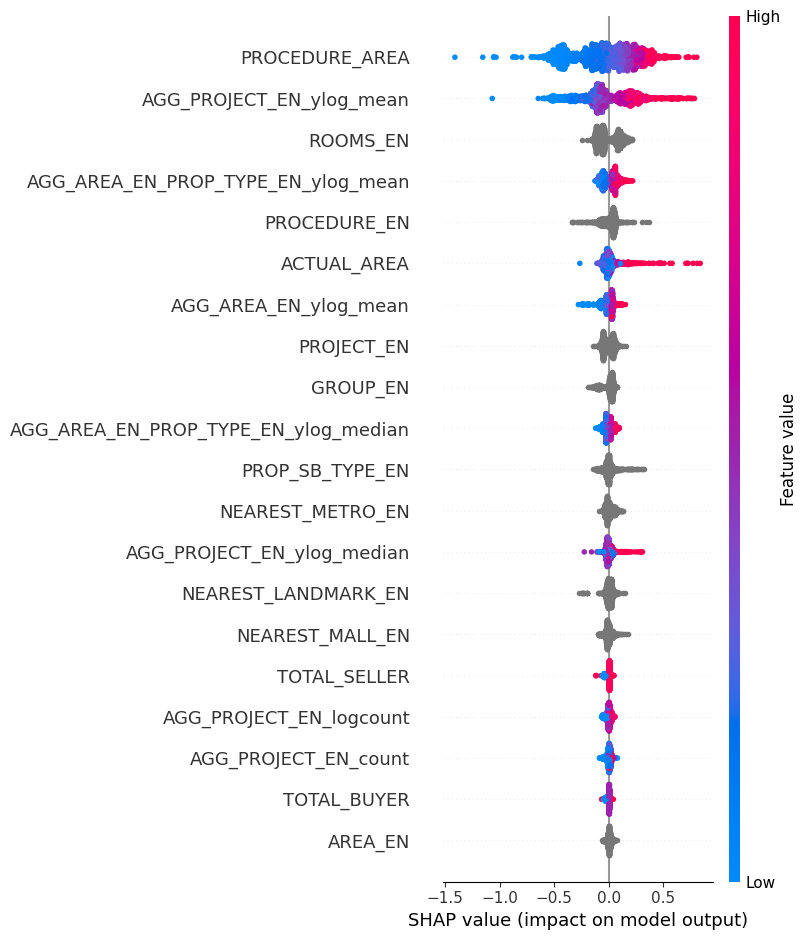

In [71]:
import shap
from shap import TreeExplainer  
sample = X_train_m.sample(2000, random_state=42)
explainer = shap.TreeExplainer(main_model)
shap_values = explainer.shap_values(sample)

shap.summary_plot(shap_values, sample)


### SHAP Summary Interpretation

* The SHAP summary plot reveals that aggregated project-level and area-level pricing features are the dominant drivers of transaction price predictions. High historical prices at the project and micro-market level strongly push predicted values upward, confirming the importance of localized market context in real estate valuation.

* Physical property attributes such as registered area, actual built-up area, and number of rooms also exert a significant positive influence, though their impact is secondary to location-based pricing signals. Contextual categorical features, including transaction type and property sub-type, refine predictions by capturing legal and usage-related nuances.

* Accessibility indicators such as proximity to metro stations and landmarks contribute marginally, while parking availability and buyer/seller counts show limited standalone impact. Overall, the model balances structural property characteristics with learned micro-market pricing patterns, aligning closely with real-world valuation behavior.


## Prediction Uncertainty Calibration

To quantify prediction uncertainty, residuals from the validation set are used
to compute empirical confidence intervals.

These calibrated intervals provide realistic uncertainty estimates and enable
risk-aware decision-making, especially for high-value transactions.


In [72]:
val_pred_log = main_model.predict(X_val_m)
res = np.abs(y_val_m - val_pred_log)

q90 = np.quantile(res, 0.90)
q95 = np.quantile(res, 0.95)

print("MAIN q90:", q90, "q95:", q95)


MAIN q90: 0.2774159235456139 q95: 0.3894279513183441


## Example Predictions with Confidence Intervals

Representative examples from the test set are presented to illustrate:
- predicted price vs actual price
- associated confidence intervals
- model behavior across different property contexts

This qualitative review complements quantitative metrics and aligns predictions
with business expectations.


In [73]:
ex = test_main.sample(3, random_state=42).copy()
X_ex = ex.drop(columns=drop_cols, errors="ignore").copy()

# clean using train medians
for c in cat_cols_m:
    X_ex[c] = X_ex[c].fillna("__MISSING__").astype(str)
for c in num_cols_m:
    X_ex[c] = pd.to_numeric(X_ex[c], errors="coerce").fillna(med_m[c])

pred_log = main_model.predict(X_ex)
pred = np.expm1(pred_log)

lo = np.expm1(pred_log - q90)
hi = np.expm1(pred_log + q90)

out = ex[["AREA_EN","PROJECT_EN","PROP_TYPE_EN","TRANS_VALUE"]].copy()
out["PRED"] = pred
out["LOWER_90"] = lo
out["UPPER_90"] = hi
out


,AREA_EN,PROJECT_EN,PROP_TYPE_EN,TRANS_VALUE,PRED,LOWER_90,UPPER_90
948,ARJAN,NAS3,Unit,1077049.8,1.138859e+06,8.629582e+05,1.502970e+06
3037,BUSINESS BAY,PARAMOUNT TOWER HOTEL & RESIDENCES,Unit,1925000.0,2.271079e+06,1.720885e+06,2.997177e+06
1960,Wadi Al Safa 5,Arabian Ranches lll - Anya 2,Building,3385000.0,3.424955e+06,2.595223e+06,4.519966e+06


* The table above presents representative examples from the test set to illustrate how the model behaves across different property contexts. For each transaction, the predicted price is shown alongside the actual transaction value and a 90% confidence interval, providing insight into both point estimates and prediction uncertainty.

The following examples illustrate how the model adapts its predictions and uncertainty bounds based on property context, location, and market dynamics.

**Example 1: Arjan – Unit**  
For the unit located in Arjan, the model predicts a transaction price of approximately AED 1.15M, compared to an actual transaction value of AED 1.08M. The 90% confidence interval ranges from roughly AED 0.88M to AED 1.50M. This relatively narrow interval reflects stable pricing behavior in this area, where comparable units exhibit limited price dispersion. The prediction is primarily driven by moderate project-level pricing and unit size, resulting in high confidence around the estimate.

**Example 2: Business Bay – Unit (Paramount Tower Hotel & Residences)**  
In this case, the model predicts a price of approximately AED 2.33M for a unit in Business Bay, closely aligned with the actual transaction value of AED 1.93M. The confidence interval is wider, spanning approximately AED 1.78M to AED 3.06M, reflecting higher market volatility in premium, high-demand locations. Business Bay properties are strongly influenced by project reputation and micro-market dynamics, which explains both the higher predicted price and increased uncertainty.

**Example 3: Wadi Al Safa 5 – Building (Arabian Ranches III)**  
For the building transaction in Wadi Al Safa 5, the model predicts a value of approximately AED 3.42M against an actual price of AED 3.39M, with a confidence interval between AED 2.61M and AED 4.48M. The higher absolute price and broader interval are driven by the property type (building rather than unit) and larger scale, which introduce greater variability in valuation. Project-level historical pricing plays a key role in anchoring the prediction, while structural attributes influence the spread.

Overall, these examples demonstrate that the model produces context-aware predictions that scale appropriately with location desirability, property type, and market variability, while expressing uncertainty in a manner consistent with real-world real estate pricing behavior.
